<a href="https://colab.research.google.com/github/edyoda/AI-Agent-Development-and-GenAI/blob/main/Day2_GenAI_Foundations_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. What is a VAE?
A Variational Autoencoder (VAE) is a probabilistic generative model that:

* Encodes data into a latent space (compressed representation).

* Decodes samples from this latent space to generate new data.

* Balances reconstruction accuracy and latent space regularization.

**Encoder:** Maps input images to the parameters (mean and log variance) of the latent distribution.

**Sampling Layer:** Uses the reparameterization trick to generate latent vectors.

**Decoder:** Reconstructs images from latent vectors.

**KL Divergence Loss:** Regularizes the latent space to match a standard normal distribution.

**Training:** The model is trained to minimize reconstruction loss (binary cross-entropy) and KL divergence.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and flatten images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), 28*28))
x_test = x_test.reshape((len(x_test), 28*28))

In [ ]:
original_dim = 784  # 28x28
latent_dim = 2       # Latent space dimension
intermediate_dim = 256  # Intermediate layer size

In [ ]:
# Encoder network
encoder_inputs = keras.Input(shape=(original_dim,))
x = layers.Dense(intermediate_dim, activation='relu')(encoder_inputs)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name='encoder')

In [ ]:
class Sampling(layers.Layer):
    """Reparameterization trick to sample from a Gaussian distribution."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Decoder network
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
decoder_outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

In [ ]:
from tensorflow.keras import backend as K

class KLDivergenceLayer(layers.Layer):
    """Custom layer to compute KL divergence loss."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
        kl_loss = K.mean(kl_loss)
        self.add_loss(kl_loss)
        return inputs  # Pass through the inputs unchanged

In [ ]:
# VAE model with KL loss layer
vae_inputs = keras.Input(shape=(original_dim,))
z_mean, z_log_var = encoder(vae_inputs)

# Add KL divergence loss via custom layer
z_mean, z_log_var = KLDivergenceLayer()([z_mean, z_log_var])

z = Sampling()([z_mean, z_log_var])
vae_outputs = decoder(z)
vae = keras.Model(vae_inputs, vae_outputs, name='vae')

In [ ]:
vae.compile(optimizer='adam', loss='binary_crossentropy')
vae.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test))

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.4102 - val_loss: 0.2654
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.2648 - val_loss: 0.2633
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2634 - val_loss: 0.2630
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.2630 - val_loss: 0.2628
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.2630 - val_loss: 0.2628
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.2632 - val_loss: 0.2628
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.2629 - val_loss: 0.2626
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.2631 - val_loss: 0.2627
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.2630 - val_loss: 0.2627
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2629 - val_loss: 0.2627
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.2629 - val_loss: 0.2628
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━

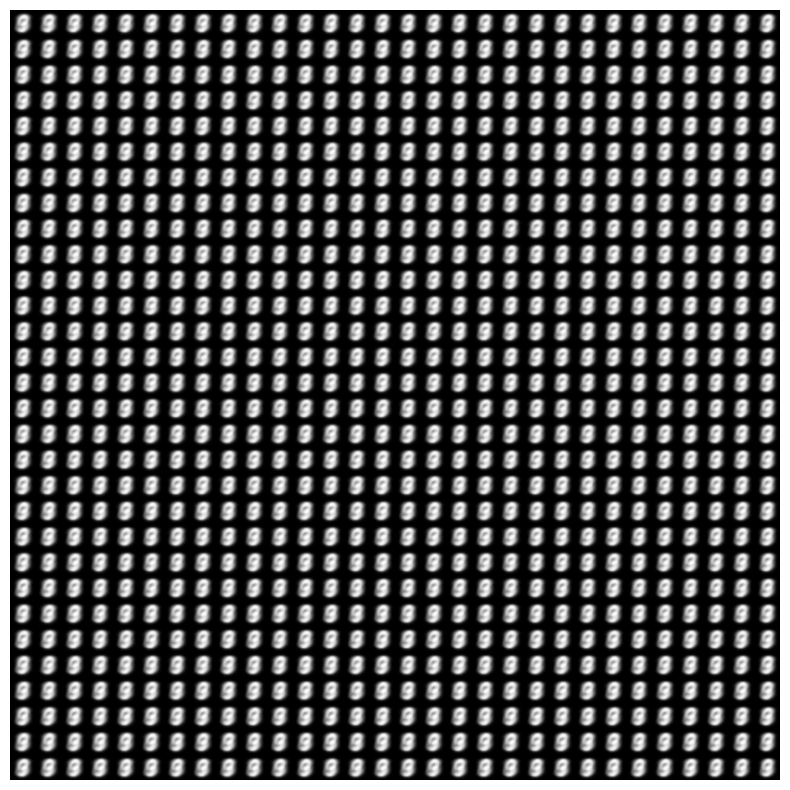

In [ ]:
# Display a 2D manifold of generated digits
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
              j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


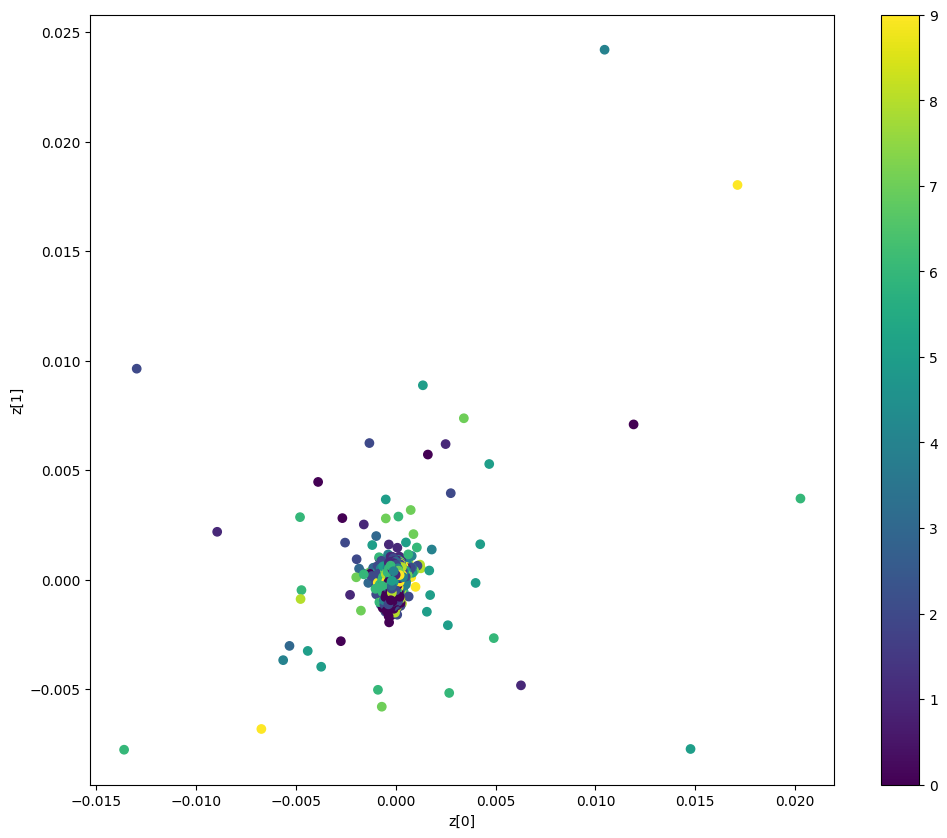

In [ ]:
# Encode test set and plot latent space
z_mean, _ = encoder.predict(x_test)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()